<a href="https://colab.research.google.com/github/manypeople-AI/-/blob/main/miniproject_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive


drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/My Drive/mini_project

/content/gdrive/My Drive/mini_project


In [4]:
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
categ = pd.read_csv("item_categories.csv")
train = pd.read_csv("sales_train.csv")

test= pd.read_csv("test.csv").set_index('ID')
submission = pd.read_csv("sample_submission.csv")

## EDA & 전처리

Train data 결측치/ 이상치/ 중복행 제거

In [5]:
#train data 결측치 확인
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

결측치 없음

In [6]:
#train/test data 중복 여부 확인
sum(train.duplicated()), sum(test.duplicated())

(6, 0)

In [7]:
#item, category, shops 중복 여부 확인
sum(items.duplicated()), sum(categ.duplicated()),sum(shops.duplicated())

(0, 0, 0)

train data에 중복행이 6개 존재한다

In [8]:
#중복행 제거해주기
train.drop_duplicates(inplace=True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935843 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.8+ MB


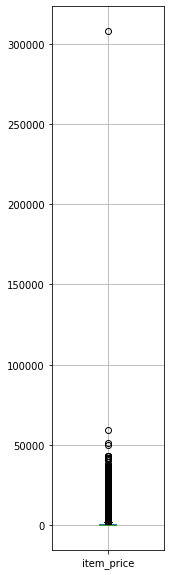

In [10]:
#이상치 처리
import seaborn as sns
import matplotlib.pyplot as plt

#상자 그림 - item price
plt.figure(figsize=(2,10))
train.boxplot(column=['item_price'])
plt.show()

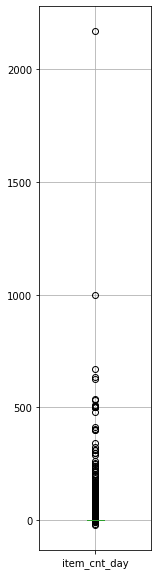

In [11]:
#상자그림 -item cnt day(하루에 해당 item이 팔린 갯수)
plt.figure(figsize=(2,10))
train.boxplot(column=['item_cnt_day'])
plt.show()

In [12]:
train = train[train.item_price<=100000]
train = train[train.item_cnt_day<=1002]
train = train[train.item_price>=0]
train = train[train.item_cnt_day>=0]

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928484 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.4+ MB


Shops data / 범주형 데이터 처리

In [14]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [15]:
#shop_name에서 제일 앞의 글자가 도시
#'도시'열을 추가해주기

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x:x[0])

In [16]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [17]:
#city 이름별로 인코딩하기

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit(list(shops['city'].values))
shops['city'] = LE.transform(list(shops['city'].values))

In [18]:
shops.drop(['shop_name'], axis=1,inplace=True)

In [19]:
shops.head()

,shop_id,city
0,0,0
1,1,0
2,2,1
3,3,2
4,4,3


Category data / Type, subtype 나눠주고 범주형 인코딩해주기

In [20]:
categ.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [21]:
#카테고리 이름에서 앞의 단어가 type

categ['split']=categ['item_category_name'].str.split('-')
categ['type']=categ['split'].map(lambda x:x[0].strip())
categ.head()

,item_category_name,item_category_id,split,type
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары


In [22]:
# type 인코딩 해주기
LE = LabelEncoder()
LE.fit(list(categ['type'].values))
categ['type_num']= LE.transform(list(categ['type'].values))

In [23]:
categ.head(3)

,item_category_name,item_category_id,split,type,type_num
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1


In [24]:
#split에서 두번째 subtype만 따로 꺼내주기
categ['subtype'] = categ['split'].map(lambda x:x[1].strip() if len(x) > 1 else x[0].strip())

In [25]:
#subtype 인코딩해주기
LE = LabelEncoder()
LE.fit(list(categ['subtype'].values))
categ['subtype_num'] = LE.transform(list(categ['subtype'].values))

In [26]:
categ.head()

,item_category_name,item_category_id,split,type,type_num,subtype,subtype_num
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13


In [27]:
categ= categ[['item_category_id','type_num','subtype_num']]

In [28]:
categ.head(3)

,item_category_id,type_num,subtype_num
0,0,0,29
1,1,1,9
2,2,1,10


Items data

In [29]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [30]:
#name 제거해주기
items.drop(['item_name'], axis=1, inplace=True)

In [31]:
#test data에서 shop_id의 개수

len(test.shop_id.unique())

42

In [32]:
len(test.item_id.unique())

5100

In [33]:
#shop이 42개, item이 5100개이므로, 총 test data개수는 42x5100=214200개
len(test)

214200

In [34]:
#set() -> 자료형, 집합에 관련된 것을 쉽게 처리 ex) s2=set("hello"), s2= {'e','h','l',o'}

len(set(test.item_id)-set(train.item_id))

363

In [35]:
#shop id 개수 비교
len(set(test.shop_id)-set(train.shop_id))

0

 즉 test에는 있는데, train에는 없는 item_id는 총 650개이다. -> 즉 item 단위로 모델을 구성하면 X(train data에는 없으니까)

 이때 test와 train에 있는 shop의 개수는 동일하다.

 이때 train의 feature중 date_block_num은 월을 0부터 연속된 수로 반환한 것이다.
 (13년 1월=0, 2월=1, ... , 14년 1월 =12)



In [36]:
#value_counts() : 유일한 값별로 개수 세기 ex) aaabbc -> a:3개 ,b:2개, c:1개
#train data에서 월별로 개수
len(train.date_block_num.value_counts())

34

즉 총 34개의 달이 존재
이때 우리는 (월, 상점, 상품)을 기준으로 하는 데이터프레임을 만들 필요가 있다
(우리가 예측할 것이 개별 (월, 상점, 상품)의 상품판매량이기때문)

In [37]:
from itertools import product
matrix=[]
cols=['date_block_num','shop_id','item_id']

#각 달에 각shop에서 팔린 item들을 matrix에 append
for i in range(34):
  sales = train[train.date_block_num==i]
  matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
#matrix 정렬하기
matrix.sort_values(cols, inplace=True)

각 달에 각각의 shop과 그 shop에서 팔린 각각의 item들을 matrix로 정리함

In [38]:
#matrix 생성
matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


3개의 단위로 월 세일즈량을 추가해줘야한다
극단 값에 robust하기 위해 범위는0-20
결측치는 일단 0으로 채워줌

In [39]:
#월별 합계계산
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day' : ['sum']})
group.columns=['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))

matrix를 date_block_num, shop_id, item_id에 대해서 group by한 뒤 agg를 이용해 월별 합계를 계산

In [40]:
#test data도 같은 형태로 만들어주기

#test data 는 2015년 11월을 예측. 즉 dateblocknum은 34
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [41]:
#test dataset도 위에서 만들어준 matrix에 merge해주기->matrix는 train+test set

matrix = pd.concat([matrix, test], ignore_index=True, sort = False, keys=cols)
matrix.fillna(0, inplace=True)

In [42]:
matrix.tail(3)

,date_block_num,shop_id,item_id,item_cnt_month
11098705,34,45,15757,0.0
11098706,34,45,19648,0.0
11098707,34,45,969,0.0


## Feauture engineering

In [43]:
#위에서 만들어놨던 city_code, item_category_id, type_code, subtype_code를 matrix의 feature로 넣기

matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, categ, on=['item_category_id'], how='left')
matrix['city'] = matrix['city'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_num'] = matrix['type_num'].astype(np.int8)
matrix['subtype_num'] = matrix['subtype_num'].astype(np.int8)

In [44]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,type_num,subtype_num
0,0,0,19,0.0,0,40,11,4
1,0,0,27,0.0,0,19,5,10
2,0,0,28,0.0,0,30,8,55
3,0,0,29,0.0,0,23,5,16
4,0,0,32,6.0,0,40,11,4


lag feature들 생성
(해당 달의 이전 달들의 여러값(Lag)을 현재 달의 Feature로 둘 필요가 있음)

In [45]:
def lag_feature(df, lags, col):
    """
    이전 달의 feature 들을, 현재 월의 feature 로 둡니다.
    이 떄, 이전 달들의 정보는 lags 에,
    사용할 feature 들은 col 에 담겨져 있습니다.
    """
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [46]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [47]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city,item_category_id,type_num,subtype_num,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN


In [48]:
# 해당 월에, 일반적으로 상품들이 팔린 평균 개수 (즉, 월 단위로 같음.) 과 레그.

group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)


In [49]:
# 해당 월에, 각각의 상품 단위로, 팔린 상품 갯수의 평균 (즉, (월, 상품) 단위) 와 레그.

group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)


In [50]:
# 해당 월에, 각각의 상점 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점) 단위

group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)


In [51]:
# 해당 월에, 각각의 아이템 카테고리 단위로, 팔린 상품 갯수의 평균과 레그. (월, 아이템 카테고리) 단위

group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)


In [52]:
# 해당 월에, 각각의 상점에서, 아이템 카테고리 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점, 아이템 카테고리) 단위

group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)


In [53]:
# 해당 월에, 각각의 아이템 타입1 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점, 타입1) 단위

group = matrix.groupby(['date_block_num', 'shop_id', 'type_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_num'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)


In [54]:
# 해당 월에, 각각의 아이템 타입2 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점, 타입2) 단위

group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_num'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)


In [55]:
# 해당 월에, 도시 단위로 팔린 상품 갯수의 평균과 레그 (월, 도시) 단위

group = matrix.groupby(['date_block_num', 'city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)


In [56]:
# 해당 월에, 각각 아이템, 도시 단위로, 팔린 상품 갯수의 평균과 레그. (월, 아이템, 도시) 단위

group = matrix.groupby(['date_block_num', 'item_id', 'city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)


In [57]:
# 해당 월에, 각각의 아이템 타입1 단위로, 팔린 상품 갯수의 평균과 레그. (월, 타입1) 단위

group = matrix.groupby(['date_block_num', 'type_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_num'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)


In [58]:
# 해당 월에, 각각의 아이템 타입2 단위로, 팔린 상품 갯수의 평균과 레그. (월, 타입2) 단위

group = matrix.groupby(['date_block_num', 'subtype_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_num'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)


# Trend features

In [59]:
# 전 기간동안의 각각 상품의 평균 가격. (상품) 단위.
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

# 월별 상품 평균 가격. (월, 상품) 단위.
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

# 월별, 각 1~6개월 전의 평균 가격 (월, 상품) 단위.
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

# 월별, 각 1~6개월 전의 평균 가격과 전 기간 평균 가격과의 차이. (월, 상품) 단위.
# 전 구간 가격 평균하고 1~6달 가격을 비교함으로써, 지난 1~6달간의 가격 트랜드를 알 수 있음.
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

# 현재 달 기준, 지난 1~6달 중, 최근의 트랜드를 찾음.
# 가장 최근 1달 전이 좋지만, 없을 경우 최대 6달 전까지 찾는 것.
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# feature drop 하기
# 가장 최근 price trend 를 찾았으니, 가격과 관련된 이전 lags 들은 필요 없음.
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)


In [60]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [61]:
# 가격 트랜드와 동일하게, 총 수입 트랜드도 잡아봄.
# 가격 트랜드 방법과 똑같음.


# 월별 각각의 상점 총 매출. (월, 상점) 단위.
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

# 전 기간동안, 각각의 상점 매출 평균. (상점) 단위.
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

# 각각 상점의 월평균 매출 - 전기간 평균매출 의 차이. (월, 상점) 단위.
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

# 가장 최근 한 달전의 총 매출만 사용.
matrix = lag_feature(matrix, [1], 'delta_revenue')

# 최근 총매출 트랜드를 얻었으니, 필요없는 Feature들 다시 삭제.
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)



# Special features

In [62]:
matrix['month'] = matrix['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [63]:
train.head(15)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,349.00
6,02.01.2013,0,25,2565,549.00,1.0,549.00
7,04.01.2013,0,25,2572,239.00,1.0,239.00
8,11.01.2013,0,25,2572,299.00,1.0,299.00
9,03.01.2013,0,25,2573,299.00,3.0,897.00
10,03.01.2013,0,25,2574,399.00,2.0,798.00


In [64]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)

# (상점, 상품)단위로, 해당 상품이 해당 월 기준, 몇 달전에 마지막으로 팔렸는지, item_shop_last_sale 에 저장.
# 예를 들어 1달 전에 팔렸으면 1임.
for idx, row in matrix.iterrows():
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num  

In [65]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)

# (상품) 단위로, 해당 상품이 해당 월 기준, 몇 달전에 마지막으로 팔렸는지, item_last_sale 에 저장.
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         

In [66]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

# Final preparations

In [67]:
matrix = matrix[matrix.date_block_num > 11]

In [68]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [69]:
import lightgbm as lgb
from lightgbm import plot_importance
import sys
import gc
import pickle

In [70]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del categ
del train
# leave test for submission
gc.collect();

*Model*; lgbm

In [71]:
data = pd.read_pickle('data.pkl')

In [72]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city',
    'item_category_id',
    'type_num',
    'subtype_num',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [73]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [74]:
del data
gc.collect();

In [75]:
!pip install optuna

     |████████████████████████████████| 296kB 12.4MB/s 
     |████████████████████████████████| 1.2MB 12.4MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 481kB 53.0MB/s 
     |████████████████████████████████| 143kB 55.7MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 112kB 62.2MB/s 
  Created wheel for alembic: filename=alembic-1.5.6-py2.py3-none-any.whl size=159505 sha256=c76312ed67d44ce058b417fa2230b6b0e4a7524309146c07a4097f3cdd71f033
  Stored in directory: /root/.cache/pip/wheels/38/5f/21/f150e4049d6c8f8edd0e8d9571fc44ff1825d6b21328b224e1
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=c680d368d820625d5bb4790e68fbcf0bc7b6d78ac84fd283328fb84a0f30cee8
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha25

In [76]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [77]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval  = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

In [83]:
def objective(trial):

    # choose parameters that you want
    
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    model = lgb.train(param, 
                      lgb_train,
                      valid_sets=[lgb_train,lgb_eval],
                      early_stopping_rounds=15, #10,
                      verbose_eval=1)
    
    y_pred = model.predict(X_valid)
    accuracy = mean_squared_error(Y_valid, y_pred,squared=False)

    return accuracy

In [98]:
from sklearn.metrics import mean_squared_error

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-03-06 06:55:48,382] A new study created in memory with name: no-name-e95fe00d-5a82-4066-968f-c1b9bb02abe5


[1]	training's rmse: 1.14182	valid_1's rmse: 1.09981
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.10017	valid_1's rmse: 1.07041
[3]	training's rmse: 1.0652	valid_1's rmse: 1.04544
[4]	training's rmse: 1.03522	valid_1's rmse: 1.0244
[5]	training's rmse: 1.01018	valid_1's rmse: 1.01047
[6]	training's rmse: 0.983754	valid_1's rmse: 0.991761
[7]	training's rmse: 0.961324	valid_1's rmse: 0.978348
[8]	training's rmse: 0.939521	valid_1's rmse: 0.964892
[9]	training's rmse: 0.923297	valid_1's rmse: 0.955757
[10]	training's rmse: 0.908767	valid_1's rmse: 0.946652
[11]	training's rmse: 0.897236	valid_1's rmse: 0.940553
[12]	training's rmse: 0.884853	valid_1's rmse: 0.937127
[13]	training's rmse: 0.875248	valid_1's rmse: 0.932574
[14]	training's rmse: 0.866344	valid_1's rmse: 0.930849
[15]	training's rmse: 0.859263	valid_1's rmse: 0.927843
[16]	training's rmse: 0.8512	valid_1's rmse: 0.92977
[17]	training's rmse: 0.845248	valid_1's rmse: 0.928682
[18]	train

[I 2021-03-06 06:56:17,342] Trial 0 finished with value: 0.9217195435145554 and parameters: {'lambda_l1': 0.1753325100044184, 'lambda_l2': 2.691429699722638e-06, 'num_leaves': 152, 'feature_fraction': 0.45811859601351174, 'bagging_fraction': 0.9638602552922726, 'bagging_freq': 2, 'min_child_samples': 52}. Best is trial 0 with value: 0.9217195435145554.


[1]	training's rmse: 1.13888	valid_1's rmse: 1.10036
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.0931	valid_1's rmse: 1.06756
[3]	training's rmse: 1.05347	valid_1's rmse: 1.04109
[4]	training's rmse: 1.02008	valid_1's rmse: 1.01729
[5]	training's rmse: 0.991474	valid_1's rmse: 1.00012
[6]	training's rmse: 0.96757	valid_1's rmse: 0.9857
[7]	training's rmse: 0.946706	valid_1's rmse: 0.977563
[8]	training's rmse: 0.928156	valid_1's rmse: 0.967277
[9]	training's rmse: 0.912416	valid_1's rmse: 0.96156
[10]	training's rmse: 0.899663	valid_1's rmse: 0.954669
[11]	training's rmse: 0.888637	valid_1's rmse: 0.951676
[12]	training's rmse: 0.87868	valid_1's rmse: 0.947292
[13]	training's rmse: 0.869875	valid_1's rmse: 0.944462
[14]	training's rmse: 0.862274	valid_1's rmse: 0.942633
[15]	training's rmse: 0.855133	valid_1's rmse: 0.940503
[16]	training's rmse: 0.849142	valid_1's rmse: 0.943038
[17]	training's rmse: 0.843938	valid_1's rmse: 0.942313
[18]	train

[I 2021-03-06 06:56:39,253] Trial 1 finished with value: 0.9403533903409941 and parameters: {'lambda_l1': 1.551087537164853e-08, 'lambda_l2': 0.0009771872605764866, 'num_leaves': 104, 'feature_fraction': 0.7435430510972324, 'bagging_fraction': 0.9598068577645767, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 0 with value: 0.9217195435145554.


[34]	training's rmse: 0.798655	valid_1's rmse: 0.94779
Early stopping, best iteration is:
[19]	training's rmse: 0.835807	valid_1's rmse: 0.940353
[1]	training's rmse: 1.13865	valid_1's rmse: 1.0989
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.09185	valid_1's rmse: 1.06463
[3]	training's rmse: 1.05059	valid_1's rmse: 1.03764
[4]	training's rmse: 1.01752	valid_1's rmse: 1.01389
[5]	training's rmse: 0.990909	valid_1's rmse: 0.997883
[6]	training's rmse: 0.966211	valid_1's rmse: 0.981341
[7]	training's rmse: 0.942528	valid_1's rmse: 0.970902
[8]	training's rmse: 0.92192	valid_1's rmse: 0.96253
[9]	training's rmse: 0.905711	valid_1's rmse: 0.956477
[10]	training's rmse: 0.892146	valid_1's rmse: 0.949142
[11]	training's rmse: 0.880386	valid_1's rmse: 0.944428
[12]	training's rmse: 0.869031	valid_1's rmse: 0.943842
[13]	training's rmse: 0.859332	valid_1's rmse: 0.944107
[14]	training's rmse: 0.850805	valid_1's rmse: 0.945679
[15]	training's rmse: 0.8433

[I 2021-03-06 06:57:05,993] Trial 2 finished with value: 0.9306968474618578 and parameters: {'lambda_l1': 2.377898622750144e-06, 'lambda_l2': 1.209691540086987e-06, 'num_leaves': 167, 'feature_fraction': 0.6814097106504045, 'bagging_fraction': 0.738453251725504, 'bagging_freq': 4, 'min_child_samples': 92}. Best is trial 0 with value: 0.9217195435145554.


[1]	training's rmse: 1.13609	valid_1's rmse: 1.09677
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.08802	valid_1's rmse: 1.06477
[3]	training's rmse: 1.04724	valid_1's rmse: 1.03764
[4]	training's rmse: 1.01292	valid_1's rmse: 1.01412
[5]	training's rmse: 0.983411	valid_1's rmse: 0.995331
[6]	training's rmse: 0.958877	valid_1's rmse: 0.979149
[7]	training's rmse: 0.937357	valid_1's rmse: 0.968002
[8]	training's rmse: 0.918266	valid_1's rmse: 0.960236
[9]	training's rmse: 0.902236	valid_1's rmse: 0.952294
[10]	training's rmse: 0.889098	valid_1's rmse: 0.946627
[11]	training's rmse: 0.876981	valid_1's rmse: 0.944446
[12]	training's rmse: 0.867	valid_1's rmse: 0.939815
[13]	training's rmse: 0.857474	valid_1's rmse: 0.940037
[14]	training's rmse: 0.849359	valid_1's rmse: 0.938204
[15]	training's rmse: 0.842151	valid_1's rmse: 0.936787
[16]	training's rmse: 0.835808	valid_1's rmse: 0.934829
[17]	training's rmse: 0.830231	valid_1's rmse: 0.933906
[18]	t

[I 2021-03-06 06:57:26,431] Trial 3 finished with value: 0.9296474469643603 and parameters: {'lambda_l1': 1.0701807135853912e-05, 'lambda_l2': 8.374373607018588e-06, 'num_leaves': 198, 'feature_fraction': 0.8908946992742164, 'bagging_fraction': 0.4301503812550074, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 0 with value: 0.9217195435145554.


[1]	training's rmse: 1.13912	valid_1's rmse: 1.09983
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.09499	valid_1's rmse: 1.07033
[3]	training's rmse: 1.05762	valid_1's rmse: 1.04573
[4]	training's rmse: 1.0259	valid_1's rmse: 1.02381
[5]	training's rmse: 0.998629	valid_1's rmse: 1.00738
[6]	training's rmse: 0.975753	valid_1's rmse: 0.993511
[7]	training's rmse: 0.956313	valid_1's rmse: 0.983015
[8]	training's rmse: 0.939445	valid_1's rmse: 0.973255
[9]	training's rmse: 0.925066	valid_1's rmse: 0.965
[10]	training's rmse: 0.912855	valid_1's rmse: 0.958152
[11]	training's rmse: 0.90209	valid_1's rmse: 0.953059
[12]	training's rmse: 0.893096	valid_1's rmse: 0.94788
[13]	training's rmse: 0.885183	valid_1's rmse: 0.943459
[14]	training's rmse: 0.878334	valid_1's rmse: 0.944246
[15]	training's rmse: 0.871832	valid_1's rmse: 0.941426
[16]	training's rmse: 0.866526	valid_1's rmse: 0.938526
[17]	training's rmse: 0.86176	valid_1's rmse: 0.936562
[18]	traini

[I 2021-03-06 06:57:59,092] Trial 4 finished with value: 0.9313537036571744 and parameters: {'lambda_l1': 0.007636401253545301, 'lambda_l2': 1.9700114366733092e-05, 'num_leaves': 58, 'feature_fraction': 0.9261758099861154, 'bagging_fraction': 0.9937607590786265, 'bagging_freq': 2, 'min_child_samples': 77}. Best is trial 0 with value: 0.9217195435145554.


[1]	training's rmse: 1.13918	valid_1's rmse: 1.09997
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.09518	valid_1's rmse: 1.06973
[3]	training's rmse: 1.05791	valid_1's rmse: 1.04453
[4]	training's rmse: 1.02624	valid_1's rmse: 1.02248
[5]	training's rmse: 0.998696	valid_1's rmse: 1.00519
[6]	training's rmse: 0.975984	valid_1's rmse: 0.990822
[7]	training's rmse: 0.956658	valid_1's rmse: 0.97924
[8]	training's rmse: 0.939997	valid_1's rmse: 0.968651
[9]	training's rmse: 0.92523	valid_1's rmse: 0.963759
[10]	training's rmse: 0.913124	valid_1's rmse: 0.957551
[11]	training's rmse: 0.902127	valid_1's rmse: 0.952249
[12]	training's rmse: 0.892979	valid_1's rmse: 0.947448
[13]	training's rmse: 0.885155	valid_1's rmse: 0.94296
[14]	training's rmse: 0.877832	valid_1's rmse: 0.93939
[15]	training's rmse: 0.871157	valid_1's rmse: 0.936468
[16]	training's rmse: 0.86584	valid_1's rmse: 0.933937
[17]	training's rmse: 0.86092	valid_1's rmse: 0.934693
[18]	train

[I 2021-03-06 06:58:29,734] Trial 5 finished with value: 0.9248603091063872 and parameters: {'lambda_l1': 1.3564853610825098e-07, 'lambda_l2': 0.25040771351905095, 'num_leaves': 57, 'feature_fraction': 0.9017795148401163, 'bagging_fraction': 0.9908746583924155, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 0 with value: 0.9217195435145554.


[1]	training's rmse: 1.14127	valid_1's rmse: 1.10089
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.09654	valid_1's rmse: 1.06858
[3]	training's rmse: 1.05816	valid_1's rmse: 1.04171
[4]	training's rmse: 1.02561	valid_1's rmse: 1.01763
[5]	training's rmse: 0.997994	valid_1's rmse: 1.00112
[6]	training's rmse: 0.974939	valid_1's rmse: 0.986419
[7]	training's rmse: 0.954417	valid_1's rmse: 0.978278
[8]	training's rmse: 0.936531	valid_1's rmse: 0.969357
[9]	training's rmse: 0.921934	valid_1's rmse: 0.960685
[10]	training's rmse: 0.909884	valid_1's rmse: 0.954423
[11]	training's rmse: 0.89928	valid_1's rmse: 0.948646
[12]	training's rmse: 0.8892	valid_1's rmse: 0.947318
[13]	training's rmse: 0.880422	valid_1's rmse: 0.946668
[14]	training's rmse: 0.872906	valid_1's rmse: 0.947132
[15]	training's rmse: 0.866336	valid_1's rmse: 0.944428
[16]	training's rmse: 0.860581	valid_1's rmse: 0.941936
[17]	training's rmse: 0.855654	valid_1's rmse: 0.940186
[18]	tr

[I 2021-03-06 06:58:50,336] Trial 6 finished with value: 0.9359525452745007 and parameters: {'lambda_l1': 2.1301195691247716e-08, 'lambda_l2': 0.00019239404206804488, 'num_leaves': 69, 'feature_fraction': 0.7627035413365801, 'bagging_fraction': 0.8104439668225762, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 0 with value: 0.9217195435145554.


[1]	training's rmse: 1.13605	valid_1's rmse: 1.09682
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.08799	valid_1's rmse: 1.06451
[3]	training's rmse: 1.04801	valid_1's rmse: 1.03645
[4]	training's rmse: 1.01416	valid_1's rmse: 1.01185
[5]	training's rmse: 0.984717	valid_1's rmse: 0.995958
[6]	training's rmse: 0.960367	valid_1's rmse: 0.979717
[7]	training's rmse: 0.938488	valid_1's rmse: 0.969299
[8]	training's rmse: 0.919249	valid_1's rmse: 0.960934
[9]	training's rmse: 0.902811	valid_1's rmse: 0.955657
[10]	training's rmse: 0.889211	valid_1's rmse: 0.952072
[11]	training's rmse: 0.877419	valid_1's rmse: 0.949974
[12]	training's rmse: 0.867673	valid_1's rmse: 0.946599
[13]	training's rmse: 0.85906	valid_1's rmse: 0.947327
[14]	training's rmse: 0.851203	valid_1's rmse: 0.948096
[15]	training's rmse: 0.843746	valid_1's rmse: 0.947855
[16]	training's rmse: 0.837893	valid_1's rmse: 0.946812
[17]	training's rmse: 0.83272	valid_1's rmse: 0.945132
[18]	

[I 2021-03-06 06:59:11,077] Trial 7 finished with value: 0.9359359786545541 and parameters: {'lambda_l1': 0.013335860152471282, 'lambda_l2': 0.03431092275935542, 'num_leaves': 165, 'feature_fraction': 0.9329500976508897, 'bagging_fraction': 0.5204668998074229, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 0 with value: 0.9217195435145554.


[1]	training's rmse: 1.13447	valid_1's rmse: 1.09716
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.08657	valid_1's rmse: 1.06287
[3]	training's rmse: 1.04414	valid_1's rmse: 1.03619
[4]	training's rmse: 1.00937	valid_1's rmse: 1.01096
[5]	training's rmse: 0.978386	valid_1's rmse: 0.995294
[6]	training's rmse: 0.952899	valid_1's rmse: 0.979396
[7]	training's rmse: 0.930431	valid_1's rmse: 0.96859
[8]	training's rmse: 0.910827	valid_1's rmse: 0.961071
[9]	training's rmse: 0.894394	valid_1's rmse: 0.953621
[10]	training's rmse: 0.880973	valid_1's rmse: 0.946811
[11]	training's rmse: 0.869077	valid_1's rmse: 0.943779
[12]	training's rmse: 0.857108	valid_1's rmse: 0.943958
[13]	training's rmse: 0.846725	valid_1's rmse: 0.945208
[14]	training's rmse: 0.837966	valid_1's rmse: 0.942608
[15]	training's rmse: 0.829894	valid_1's rmse: 0.945564
[16]	training's rmse: 0.823105	valid_1's rmse: 0.948087
[17]	training's rmse: 0.816923	valid_1's rmse: 0.949085
[18]

[I 2021-03-06 06:59:27,815] Trial 8 finished with value: 0.9426076360038905 and parameters: {'lambda_l1': 0.3370839049509881, 'lambda_l2': 0.0002798110881914288, 'num_leaves': 224, 'feature_fraction': 0.7991216963686452, 'bagging_fraction': 0.614796502766487, 'bagging_freq': 3, 'min_child_samples': 12}. Best is trial 0 with value: 0.9217195435145554.


[29]	training's rmse: 0.775064	valid_1's rmse: 0.947253
Early stopping, best iteration is:
[14]	training's rmse: 0.837966	valid_1's rmse: 0.942608
[1]	training's rmse: 1.13574	valid_1's rmse: 1.09615
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.08908	valid_1's rmse: 1.06383
[3]	training's rmse: 1.04863	valid_1's rmse: 1.03626
[4]	training's rmse: 1.0145	valid_1's rmse: 1.01259
[5]	training's rmse: 0.985573	valid_1's rmse: 0.993812
[6]	training's rmse: 0.961011	valid_1's rmse: 0.978706
[7]	training's rmse: 0.939295	valid_1's rmse: 0.970644
[8]	training's rmse: 0.920372	valid_1's rmse: 0.964123
[9]	training's rmse: 0.904373	valid_1's rmse: 0.958232
[10]	training's rmse: 0.891013	valid_1's rmse: 0.954276
[11]	training's rmse: 0.878858	valid_1's rmse: 0.948987
[12]	training's rmse: 0.868716	valid_1's rmse: 0.945881
[13]	training's rmse: 0.85982	valid_1's rmse: 0.94333
[14]	training's rmse: 0.851868	valid_1's rmse: 0.940887
[15]	training's rmse: 0.844

[I 2021-03-06 06:59:57,592] Trial 9 finished with value: 0.9358133171197716 and parameters: {'lambda_l1': 0.2608708507964203, 'lambda_l2': 0.018086066351322046, 'num_leaves': 147, 'feature_fraction': 0.864060408407847, 'bagging_fraction': 0.9765548832688007, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 0 with value: 0.9217195435145554.


[1]	training's rmse: 1.14144	valid_1's rmse: 1.09903
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.09946	valid_1's rmse: 1.06935
[3]	training's rmse: 1.06265	valid_1's rmse: 1.04384
[4]	training's rmse: 1.03152	valid_1's rmse: 1.02169
[5]	training's rmse: 1.00513	valid_1's rmse: 1.00648
[6]	training's rmse: 0.978143	valid_1's rmse: 0.987556
[7]	training's rmse: 0.956202	valid_1's rmse: 0.972623
[8]	training's rmse: 0.933136	valid_1's rmse: 0.958721
[9]	training's rmse: 0.916117	valid_1's rmse: 0.94921
[10]	training's rmse: 0.901134	valid_1's rmse: 0.939927
[11]	training's rmse: 0.889239	valid_1's rmse: 0.934224
[12]	training's rmse: 0.877816	valid_1's rmse: 0.928623
[13]	training's rmse: 0.867759	valid_1's rmse: 0.924379
[14]	training's rmse: 0.857595	valid_1's rmse: 0.923769
[15]	training's rmse: 0.850225	valid_1's rmse: 0.921018
[16]	training's rmse: 0.841407	valid_1's rmse: 0.924962
[17]	training's rmse: 0.834876	valid_1's rmse: 0.924191
[18]	t

[I 2021-03-06 07:00:12,068] Trial 10 finished with value: 0.9210184047771358 and parameters: {'lambda_l1': 8.932856729787584, 'lambda_l2': 1.2405291653011e-08, 'num_leaves': 247, 'feature_fraction': 0.41984793943517096, 'bagging_fraction': 0.8593233981946952, 'bagging_freq': 1, 'min_child_samples': 41}. Best is trial 10 with value: 0.9210184047771358.


[30]	training's rmse: 0.787882	valid_1's rmse: 0.92688
Early stopping, best iteration is:
[15]	training's rmse: 0.850225	valid_1's rmse: 0.921018
[1]	training's rmse: 1.14116	valid_1's rmse: 1.09975
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.09909	valid_1's rmse: 1.0702
[3]	training's rmse: 1.06243	valid_1's rmse: 1.04488
[4]	training's rmse: 1.03138	valid_1's rmse: 1.02388
[5]	training's rmse: 1.00489	valid_1's rmse: 1.00795
[6]	training's rmse: 0.977894	valid_1's rmse: 0.988642
[7]	training's rmse: 0.955814	valid_1's rmse: 0.973544
[8]	training's rmse: 0.933075	valid_1's rmse: 0.959611
[9]	training's rmse: 0.915913	valid_1's rmse: 0.950097
[10]	training's rmse: 0.901054	valid_1's rmse: 0.94051
[11]	training's rmse: 0.889466	valid_1's rmse: 0.934569
[12]	training's rmse: 0.878025	valid_1's rmse: 0.92901
[13]	training's rmse: 0.86783	valid_1's rmse: 0.924829
[14]	training's rmse: 0.857593	valid_1's rmse: 0.923312
[15]	training's rmse: 0.850244	

[I 2021-03-06 07:00:26,583] Trial 11 finished with value: 0.920244748393281 and parameters: {'lambda_l1': 8.34041998531167, 'lambda_l2': 1.5684168833773153e-08, 'num_leaves': 253, 'feature_fraction': 0.41280223396102617, 'bagging_fraction': 0.8473708260325244, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 11 with value: 0.920244748393281.


[30]	training's rmse: 0.788098	valid_1's rmse: 0.923795
Early stopping, best iteration is:
[15]	training's rmse: 0.850244	valid_1's rmse: 0.920245
[1]	training's rmse: 1.14416	valid_1's rmse: 1.10375
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.10251	valid_1's rmse: 1.0748
[3]	training's rmse: 1.06471	valid_1's rmse: 1.05102
[4]	training's rmse: 1.03449	valid_1's rmse: 1.03049
[5]	training's rmse: 1.00843	valid_1's rmse: 1.01585
[6]	training's rmse: 0.980682	valid_1's rmse: 0.995623
[7]	training's rmse: 0.95831	valid_1's rmse: 0.98078
[8]	training's rmse: 0.934901	valid_1's rmse: 0.967125
[9]	training's rmse: 0.917427	valid_1's rmse: 0.957166
[10]	training's rmse: 0.902557	valid_1's rmse: 0.947589
[11]	training's rmse: 0.890718	valid_1's rmse: 0.941909
[12]	training's rmse: 0.878769	valid_1's rmse: 0.936132
[13]	training's rmse: 0.867786	valid_1's rmse: 0.932745
[14]	training's rmse: 0.85704	valid_1's rmse: 0.933534
[15]	training's rmse: 0.851752

[I 2021-03-06 07:00:42,227] Trial 12 finished with value: 0.93078008066909 and parameters: {'lambda_l1': 4.934091519910332, 'lambda_l2': 2.20472591997966e-08, 'num_leaves': 249, 'feature_fraction': 0.4051720700520376, 'bagging_fraction': 0.8686223876961277, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 11 with value: 0.920244748393281.


[1]	training's rmse: 1.13955	valid_1's rmse: 1.09896
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.09556	valid_1's rmse: 1.06792
[3]	training's rmse: 1.05213	valid_1's rmse: 1.04144
[4]	training's rmse: 1.01781	valid_1's rmse: 1.01668
[5]	training's rmse: 0.991624	valid_1's rmse: 1.00081
[6]	training's rmse: 0.965955	valid_1's rmse: 0.983808
[7]	training's rmse: 0.943499	valid_1's rmse: 0.970515
[8]	training's rmse: 0.921595	valid_1's rmse: 0.959747
[9]	training's rmse: 0.904556	valid_1's rmse: 0.949673
[10]	training's rmse: 0.890167	valid_1's rmse: 0.942181
[11]	training's rmse: 0.878496	valid_1's rmse: 0.933465
[12]	training's rmse: 0.86476	valid_1's rmse: 0.934933
[13]	training's rmse: 0.853062	valid_1's rmse: 0.936559
[14]	training's rmse: 0.843813	valid_1's rmse: 0.93748
[15]	training's rmse: 0.836578	valid_1's rmse: 0.934788
[16]	training's rmse: 0.8292	valid_1's rmse: 0.933946
[17]	training's rmse: 0.8218	valid_1's rmse: 0.933329
[18]	train

[I 2021-03-06 07:00:59,150] Trial 13 finished with value: 0.9316063808359558 and parameters: {'lambda_l1': 8.78090807238222, 'lambda_l2': 1.3168963163452203e-08, 'num_leaves': 251, 'feature_fraction': 0.5458570382527669, 'bagging_fraction': 0.8631096243952004, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 11 with value: 0.920244748393281.


[1]	training's rmse: 1.14019	valid_1's rmse: 1.09972
Training until validation scores don't improve for 15 rounds.
[2]	training's rmse: 1.09655	valid_1's rmse: 1.06926
[3]	training's rmse: 1.05438	valid_1's rmse: 1.04016
[4]	training's rmse: 1.02061	valid_1's rmse: 1.016
[5]	training's rmse: 0.995035	valid_1's rmse: 1.00206
[6]	training's rmse: 0.969695	valid_1's rmse: 0.984869
[7]	training's rmse: 0.947617	valid_1's rmse: 0.971745
[8]	training's rmse: 0.926383	valid_1's rmse: 0.960965
[9]	training's rmse: 0.90958	valid_1's rmse: 0.951303
[10]	training's rmse: 0.89544	valid_1's rmse: 0.944158
[11]	training's rmse: 0.884309	valid_1's rmse: 0.937732
[12]	training's rmse: 0.871217	valid_1's rmse: 0.93623
[13]	training's rmse: 0.859907	valid_1's rmse: 0.935813
[14]	training's rmse: 0.851159	valid_1's rmse: 0.935563
[15]	training's rmse: 0.844107	valid_1's rmse: 0.932686
[16]	training's rmse: 0.836572	valid_1's rmse: 0.936065
[17]	training's rmse: 0.829593	valid_1's rmse: 0.938576
[18]	trai

[I 2021-03-06 07:01:13,820] Trial 14 finished with value: 0.9326858530708169 and parameters: {'lambda_l1': 8.052373616848797, 'lambda_l2': 1.41645798415209e-07, 'num_leaves': 211, 'feature_fraction': 0.5465095670683557, 'bagging_fraction': 0.7430337699801673, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 11 with value: 0.920244748393281.


[30]	training's rmse: 0.784727	valid_1's rmse: 0.939622
Early stopping, best iteration is:
[15]	training's rmse: 0.844107	valid_1's rmse: 0.932686
Number of finished trials: 15
Best trial: {'lambda_l1': 8.34041998531167, 'lambda_l2': 1.5684168833773153e-08, 'num_leaves': 253, 'feature_fraction': 0.41280223396102617, 'bagging_fraction': 0.8473708260325244, 'bagging_freq': 1, 'min_child_samples': 43}


In [85]:
best_params = study.best_trial.params
print(f'Best trial parameters\n{best_params}')

Best trial parameters
{'lambda_l1': 0.02357434672036844, 'lambda_l2': 0.5380330742362078, 'num_leaves': 32, 'feature_fraction': 0.7669798053944352, 'bagging_fraction': 0.9759236056047874, 'bagging_freq': 4, 'min_child_samples': 59}


In [86]:
# add some fix params

x = {"objective": "regression",
     "metric"   : "rmse",
     "verbosity": -1,
     "boosting_type": "gbdt"}

best_params.update(x)
best_params

{'bagging_fraction': 0.9759236056047874,
 'bagging_freq': 4,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.7669798053944352,
 'lambda_l1': 0.02357434672036844,
 'lambda_l2': 0.5380330742362078,
 'metric': 'rmse',
 'min_child_samples': 59,
 'num_leaves': 32,
 'objective': 'regression',
 'verbosity': -1}

In [87]:
evals_result = {} 

model = lgb.train(best_params,
                  lgb_train,
                  valid_sets=[lgb_train,lgb_eval],

                  evals_result=evals_result,
                  early_stopping_rounds=10, # 20
                  verbose_eval=1,
                  )

[1]	training's rmse: 1.14475	valid_1's rmse: 1.10151
Training until validation scores don't improve for 30 rounds.
[2]	training's rmse: 1.10209	valid_1's rmse: 1.07101
[3]	training's rmse: 1.06709	valid_1's rmse: 1.0466
[4]	training's rmse: 1.03606	valid_1's rmse: 1.0252
[5]	training's rmse: 1.01028	valid_1's rmse: 1.00762
[6]	training's rmse: 0.987478	valid_1's rmse: 0.992993
[7]	training's rmse: 0.968832	valid_1's rmse: 0.982612
[8]	training's rmse: 0.95258	valid_1's rmse: 0.972952
[9]	training's rmse: 0.939258	valid_1's rmse: 0.965974
[10]	training's rmse: 0.927741	valid_1's rmse: 0.958805
[11]	training's rmse: 0.917791	valid_1's rmse: 0.952451
[12]	training's rmse: 0.909094	valid_1's rmse: 0.946631
[13]	training's rmse: 0.901496	valid_1's rmse: 0.943074
[14]	training's rmse: 0.895126	valid_1's rmse: 0.940302
[15]	training's rmse: 0.88897	valid_1's rmse: 0.936925
[16]	training's rmse: 0.88401	valid_1's rmse: 0.935011
[17]	training's rmse: 0.879389	valid_1's rmse: 0.934024
[18]	train

In [90]:
y_pred = model.predict(X_valid)
mean_squared_error(Y_valid, y_pred,squared=False)

0.924626828414807

Plot metrics recorded during training...


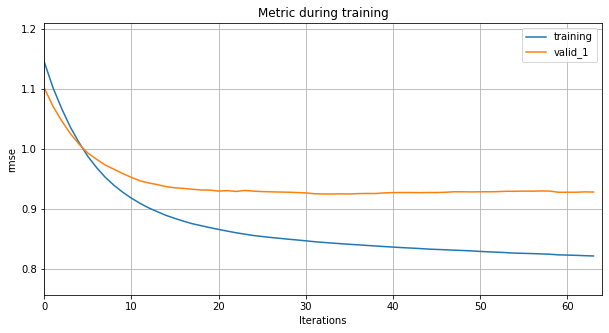

In [94]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, figsize=(10, 5))

In [96]:
# predicting model

Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.head(10)

,ID,item_cnt_month
0,0,0.561747
1,1,0.445191
2,2,1.033932
3,3,0.405025
4,4,2.853969
5,5,0.580685
6,6,1.088060
7,7,0.113660
8,8,0.767736
9,9,0.902940


In [97]:
submission.to_csv('lgbm submission.csv', index=False)